In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Layer, Dense, Flatten, Dropout, Concatenate, Add, Dot, Multiply, Reshape, Activation, BatchNormalization, SimpleRNNCell, RNN, SimpleRNN, LSTM, Embedding, Bidirectional, TimeDistributed, Conv1D, Conv2D, MaxPool1D, MaxPool2D, GlobalMaxPool1D, GlobalMaxPool2D, AveragePooling1D, AveragePooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, CosineSimilarity
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.activations import linear, sigmoid, relu
from tensorflow.keras.initializers import RandomNormal, glorot_uniform, he_uniform, Constant
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

plt.style.use("dark_background")

In [10]:
df = pd.read_csv("./Datasets/Gemini_ETHUSD_d.csv",  
                 skiprows=1, 
                 parse_dates=True, 
                 index_col='Date')

df = df.sort_index().drop(['Symbol','Unix Timestamp'] , axis=1)
df.head()

,Open,High,Low,Close,Volume ETH,Volume USD
Date,,,,,,
2016-05-09,12.00,12.00,9.36,9.98,1317.90,12885.06
2016-05-10,9.98,9.98,9.36,9.68,672.06,6578.20
2016-05-11,9.68,10.47,9.68,10.43,3052.51,30978.11
2016-05-12,10.43,12.00,9.92,10.20,2072.56,22183.39
2016-05-13,10.20,11.59,10.20,10.69,1769.71,18923.55


<AxesSubplot:xlabel='Date'>

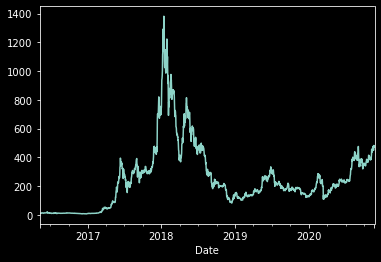

In [11]:
df['Close'].plot()

In [12]:
df.index.max()

Timestamp('2020-11-20 00:00:00')

In [13]:
# Block
test_cutoff_date = df.index.max() - timedelta(days=90)

df_test = df[df.index > test_cutoff_date]['Close']
df_train = df[df.index <= test_cutoff_date]['Close']


Single Step

<AxesSubplot:xlabel='Date'>

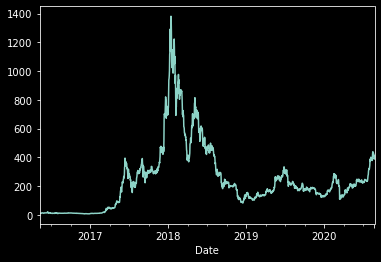

In [14]:
df_train.plot()

<AxesSubplot:xlabel='Date'>

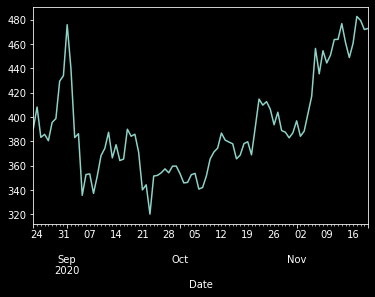

In [15]:
df_test.plot()

In [16]:
from numpy import array

# Block

def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

raw_seq = df_train
n_steps = 30

X, y = split_sequence(raw_seq, n_steps)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [18]:
# CNN 모델을 만드는 부분.
# TCN (Temporal Conv. NN)
model = keras.Sequential()
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, 1))) # 29, 64
model.add(layers.MaxPooling1D(pool_size=2)) # 14,64
model.add(layers.Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(n_steps, 1))) # 13,128
model.add(layers.MaxPooling1D(pool_size=2)) # 6,128
model.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(n_steps, 1))) # 5, 256
model.add(layers.MaxPooling1D(pool_size=2)) # 2, 256
model.add(layers.Flatten()) # 512
model.add(layers.Dense(50, activation='relu')) # 뉴럴 네트워크
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 29, 64)            192       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 14, 64)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 13, 128)           16512     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 6, 128)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 5, 256)            65792     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 2, 256)          

In [19]:
hist = model.fit(X, y, epochs=100, batch_size=64)

ERROR! Session/line number was not unique in database. History logging moved to new session 883
Epoch 1/100
25/25 [==============================] - 0s 10ms/step - loss: 36.4045
Epoch 2/100
25/25 [==============================] - 0s 12ms/step - loss: 36.5329
Epoch 3/100
25/25 [==============================] - 0s 12ms/step - loss: 36.4684
Epoch 4/100
25/25 [==============================] - 0s 15ms/step - loss: 35.9246
Epoch 5/100
25/25 [==============================] - 0s 12ms/step - loss: 36.4586
Epoch 6/100
25/25 [==============================] - 0s 12ms/step - loss: 36.9998
Epoch 7/100
25/25 [==============================] - 0s 15ms/step - loss: 35.9540
Epoch 8/100
25/25 [==============================] - 0s 13ms/step - loss: 36.0301
Epoch 9/100
25/25 [==============================] - 0s 13ms/step - loss: 36.0180
Epoch 10/100
25/25 [==============================] - 0s 13ms/step - loss: 38.4999
Epoch 11/100
25/25 [==============================] - 0s 13ms/step - loss: 38.5813


25/25 [==============================] - 0s 12ms/step - loss: 37.1851
Epoch 99/100
25/25 [==============================] - 0s 11ms/step - loss: 36.1698
Epoch 100/100
25/25 [==============================] - 0s 10ms/step - loss: 43.9681


In [20]:
train_pred = model.predict(X)

In [21]:
train_pred

array([[ 16.167715],
       [ 16.337433],
       [ 16.257452],
       ...,
       [401.12457 ],
       [430.72748 ],
       [449.30695 ]], dtype=float32)

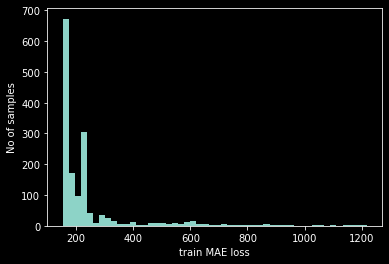

In [22]:
train_mae_loss = np.mean(np.abs(train_pred - y), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [23]:
train_df_with_pred = df_train.to_frame()[n_steps:]
train_df_with_pred['pred'] = train_pred

In [24]:
train_df_with_pred

,Close,pred
Date,,
2016-06-08,14.51,16.167715
2016-06-09,14.47,16.337433
2016-06-10,13.97,16.257452
2016-06-11,14.11,16.362663
2016-06-12,15.75,16.396551
...,...,...
2020-08-18,422.30,410.816956
2020-08-19,407.55,404.478058
2020-08-20,414.53,401.124573


<AxesSubplot:xlabel='Date'>

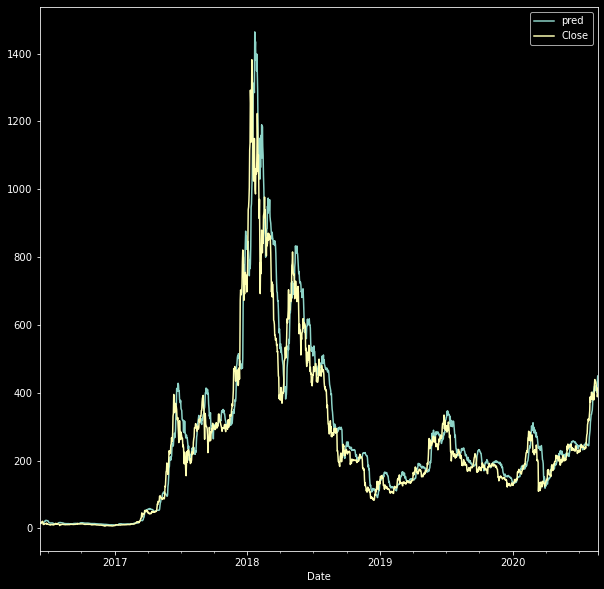

In [25]:
# Lagging = 예측값이 실제 값보다 N 스텝 앞에 있는 경우
# Forwarding = 예측값이 실제 값보다 N 스텝 뒤에 있는 경우
fig, ax = plt.subplots(figsize=(10,10))
train_df_with_pred['pred'].plot(ax=ax, legend=True)
train_df_with_pred['Close'].plot(ax=ax, legend=True)

In [26]:
test_raw_seq = df_test

test_X, test_y = split_sequence(test_raw_seq, n_steps)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [ ]:
test_X.shape

(60, 30, 1)

In [ ]:
y_pred = model.predict(test_X)

In [ ]:
y_pred.shape

(60, 1)

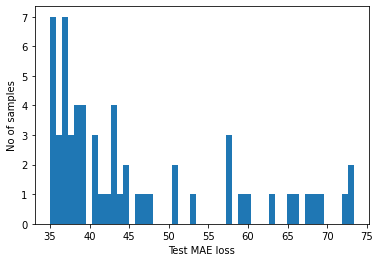

In [ ]:
test_mae_loss = np.mean(np.abs(y_pred - test_y), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel("Test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [ ]:
test_df_with_pred = df_test.to_frame()[n_steps:]
test_df_with_pred['pred'] = y_pred

In [ ]:
test_df_with_pred

,Close,pred
Date,,
2020-09-22,344.17,371.725525
2020-09-23,320.06,354.281769
2020-09-24,351.40,386.543091
2020-09-25,351.94,350.861603
2020-09-26,354.10,357.095093
2020-09-27,357.31,369.133636
2020-09-28,354.06,362.593750
2020-09-29,359.55,361.332367
2020-09-30,359.59,359.726776


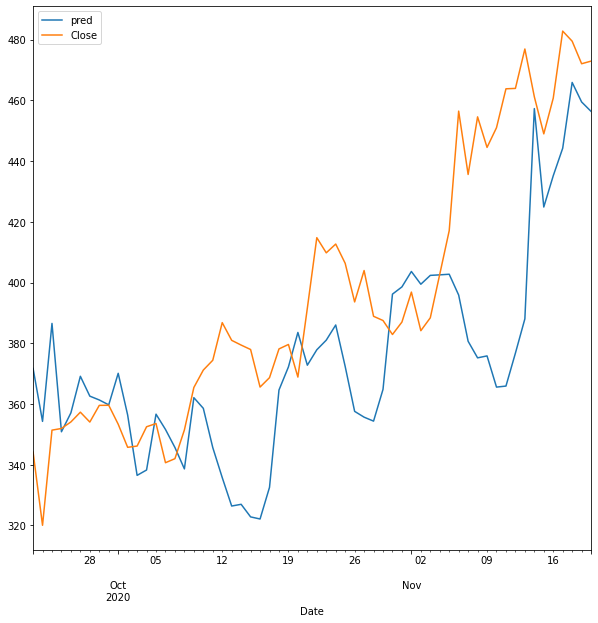

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
test_df_with_pred['pred'].plot(ax=ax, legend=True)
test_df_with_pred['Close'].plot(ax=ax, legend=True)

Multi Step

In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		if out_end_ix > len(sequence):
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
raw_seq = df_train

n_steps_in, n_steps_out = 60, 7
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
X.shape

(1501, 60, 1)

In [ ]:
model = keras.Sequential()
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
# 모델을 추가. (Seq2seq, Encoder-Decoder)
# 내가 출력할 시계열에 어떤 특징이 없을때
model.add(layers.Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae')
# model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 59, 64)            192       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 29, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1856)              0         
                                                                 
 dense_2 (Dense)             (None, 50)                92850     
                                                                 
 dense_3 (Dense)             (None, 7)                 357       
                                                                 
Total params: 93,399
Trainable params: 93,399
Non-trainable params: 0
__________________________________________________

In [ ]:
hist = model.fit(X, y, epochs=100)

Epoch 1/100
47/47 [==============================] - 1s 5ms/step - loss: 71.5031
Epoch 2/100
47/47 [==============================] - 0s 4ms/step - loss: 39.9305
Epoch 3/100
47/47 [==============================] - 0s 4ms/step - loss: 35.1119
Epoch 4/100
47/47 [==============================] - 0s 4ms/step - loss: 33.6355
Epoch 5/100
47/47 [==============================] - 0s 4ms/step - loss: 31.9250
Epoch 6/100
47/47 [==============================] - 0s 5ms/step - loss: 31.0863
Epoch 7/100
47/47 [==============================] - 0s 5ms/step - loss: 29.6755
Epoch 8/100
47/47 [==============================] - 0s 4ms/step - loss: 30.4280
Epoch 9/100
47/47 [==============================] - 0s 4ms/step - loss: 29.3942
Epoch 10/100
47/47 [==============================] - 0s 4ms/step - loss: 29.9303
Epoch 11/100
47/47 [==============================] - 0s 4ms/step - loss: 28.2522
Epoch 12/100
47/47 [==============================] - 0s 4ms/step - loss: 29.6102
Epoch 13/100
47/47 [=====

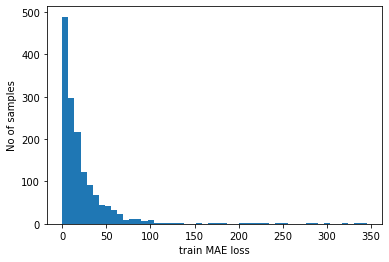

In [ ]:
train_pred = model.predict(X)

train_mae_loss = np.mean(np.abs(train_pred - y), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [ ]:
train_pred.shape

(1501, 7)

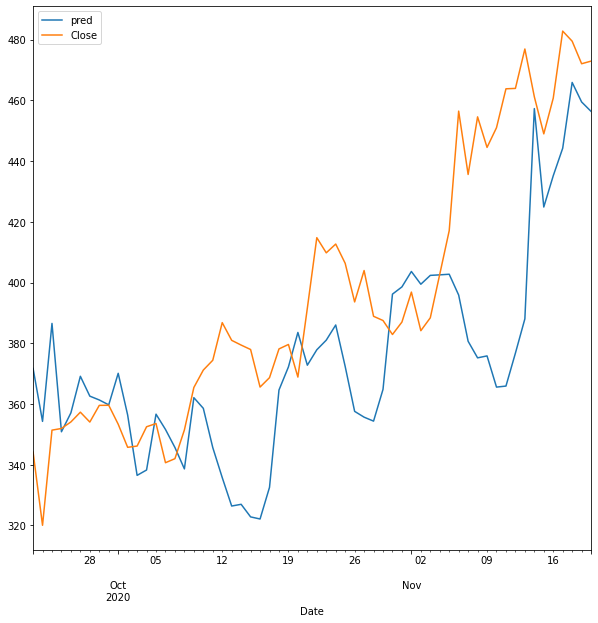

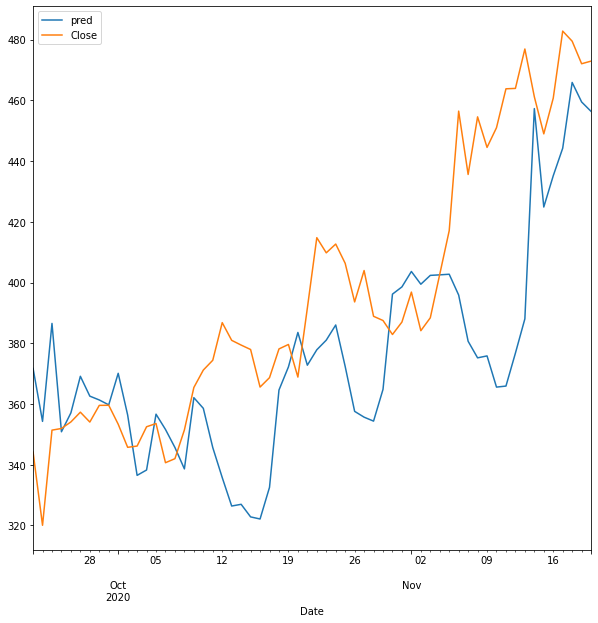

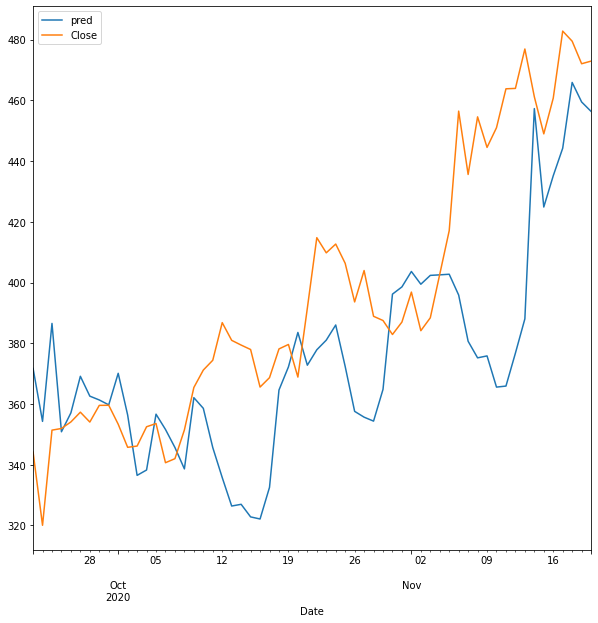

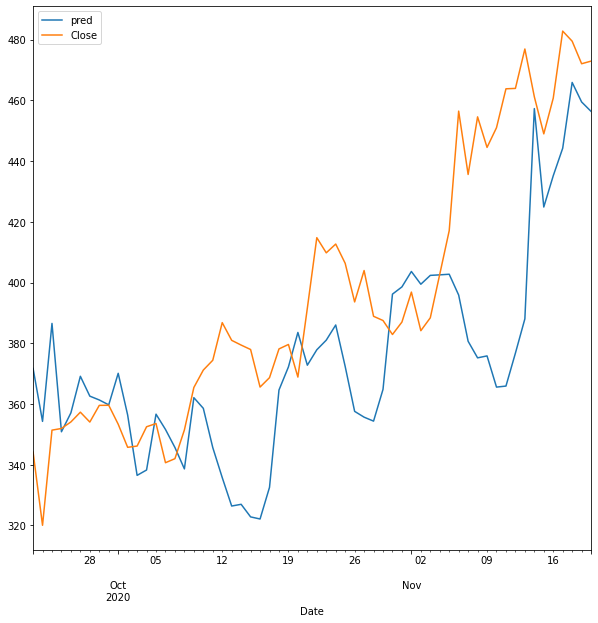

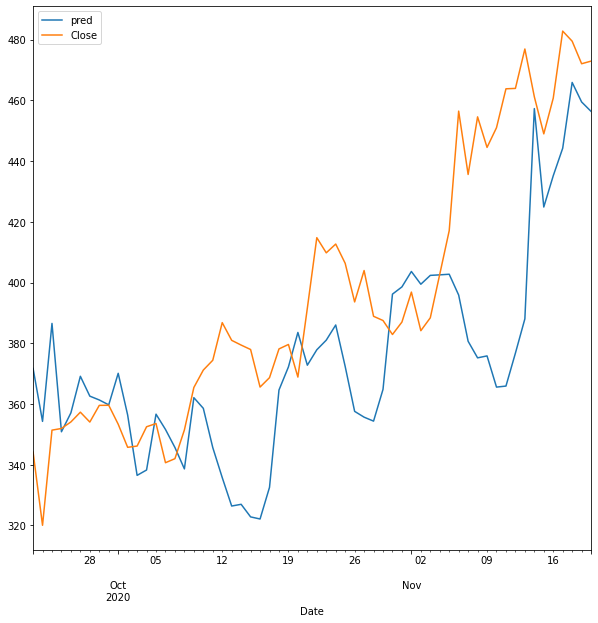

In [ ]:
for i, pred in enumerate(train_pred[:5]):
  train_df_with_pred = df_train[i:i+n_steps_out]
  train_df_with_pred['pred'] = pred
  
  fig, ax = plt.subplots(figsize=(10,10))
  test_df_with_pred['pred'].plot(ax=ax, legend=True)
  test_df_with_pred['Close'].plot(ax=ax, legend=True)
  plt.show()

In [ ]:
# TODO: TEST에 대해서도 똑같은 검증을 해보세요.